There is an awesome paper that puts a simple idea of interpretable linear regression to an absolute.
The [Intuitive Joint Priors for Bayesian Linear Multilevel Models: The R2D2M2 prior](https://arxiv.org/abs/2208.07132).
The idea resonates with me a lot since I admire interpretable priors and tha ability to describe the model, not an ability to explain.

Explaining the model, you try to interpret parameters that are already present in the model and you need to put some human readable explanation of the meaning.
It resembles me the top down approach, then you introduce parameters as you need them.

Describing the model is the opposite. 
You start with simple statements that you or your peer both understand to argue about.
It is usually referred as the bottom up approach, you start with assumpltions you understand and complete the model as you go.

Mastering the latter is the essense of the Bayesian modelling.
In this sense, the paper is of a great interest to me.

## Boston Housing Data
As a benchmark dataset I took boston housing dataset.
It has the bare minimum to check the model parametrization.
I marked in red the part of the linear regression I really need and ignored varying intercept and varying slope.

$$
\begin{equation}
\label{r2d2m2model}
    \begin{aligned}
y_n & \sim \mathcal{N} (\mu_n, \sigma^2) \\
\color{red}{\mu_n} &\color{red}{= b_{0}+ \sum_{i=1}^p x_{ni} b_{i}}+  \sum_{g\in G_0} u_{0 g_{j[n]}  }  + \sum_{i=1}^p x_{ni} \left( \sum_{g \in G_i} u_{i g_{j[n]}} \right) \\
b_{0}& \sim  p(b_{0}) \\
b_i &\sim \mathcal{N} \left(0, \frac{\sigma^2}{\sigma_{x_i}^2}   \phi_i \tau^2\right), \quad
    u_{ig_j} \sim \mathcal{N} \left(0, \frac{\sigma^2}{\sigma_{x_i}^2}   \phi_{ig} \tau^2\right) \\
    \tau^2&= \frac{R^2}{1-R^2}\\
R^2  &\sim \operatorname{Beta}(\mu_{R^2},\varphi_{R^2}), \ \
     \phi \sim \operatorname{Dirichlet} (\alpha), \ \
     \sigma \sim p(\sigma). \\
\end{aligned}
\end{equation}
$$

Let's finally get our hands dirty with code!

In [120]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import formulae
import pymc as pm
import numpy as np
import scipy.special as sp
import scipy.stats as st
import warnings
import arviz as az
import matplotlib.pyplot as plt
import nutpie
warnings.filterwarnings("ignore")
az.style.use("arviz-white")
warnings.filterwarnings("ignore")
%config InlineBackend.figure_formats = ['jpeg']

In [2]:
housing = fetch_california_housing(as_frame=True)

It has to be remarked, that I advocate to normalize your input data so it has $\mathbb{E}[X]=0$, $\mathbb{V}[X]=1$.
This will save you a lot of time to figure out the right scale for slope parameters.
Normalizing the output variable also makes a lot of sense.
You may also notice that it is actually a part of the R2D2M2 linear regression parametrizarion.
A rule of thumb is to take care of it one way or another.

$$
b_i \sim \mathcal{N} \left(0, \color{red}{\frac{\sigma^2}{\sigma_{x_i}^2}}\right)
$$

In [3]:
Xscaler = StandardScaler()

In [4]:
data = housing["data"]
target = housing["target"]

In [15]:
X = Xscaler.fit_transform(data)
mean = target.mean()
std = target.std()

### Non-centered R2D2M2
Whenever I see a normal distribution with mean and scale I tend to use non-cented parametrization.
I was shocked to see how different it is from the centered case.
But before we go to the working examples, let's see how to make an amazing model miserably fail.

In [89]:
# grade the importance of variables
# 0 - least impotant, inf - most important
# 1 - "I do not know"
alpha = np.ones(X.shape[1])
# Give me the 95% bounds of possible R2 for this linear regression
# 0 - I do not believe in this makes any sense
# 1 - I totally believe data perfectly explains the outcome 
R2 = (0.7, 0.9)

In [21]:
with pm.Model(coords=dict(variable=data.columns)) as model:
    R2p = pm.find_constrained_prior(pm.Beta, *R2, init_guess=dict(alpha=1, beta=1))
    r2 = pm.Beta("R2", **R2p)
    tau = (r2/(1-r2)) ** .5
    phi = pm.Dirichlet("phi", alpha, dims="variable")
    beta = pm.Deterministic("coef_norm", pm.Normal("coef_raw", dims="variable") * std * phi**.5 * tau, dims="variable")
    pm.Deterministic("coef", beta/Xscaler.scale_, dims="variable")
    sigma = pm.HalfStudentT("sigma", 3, std)
    intercept = pm.StudentT("intercept", 3, mean, sigma=std/4)
    estimate = X @ beta + intercept
    nu = pm.Gamma("nu", mu=20, sigma=3)
    pm.StudentT("obs", nu, estimate, sigma=sigma, observed=target)

In [22]:
import nutpie

In [23]:
compiled_model = nutpie.compile_pymc_model(model)

In [24]:
trace = nutpie.sample(compiled_model)

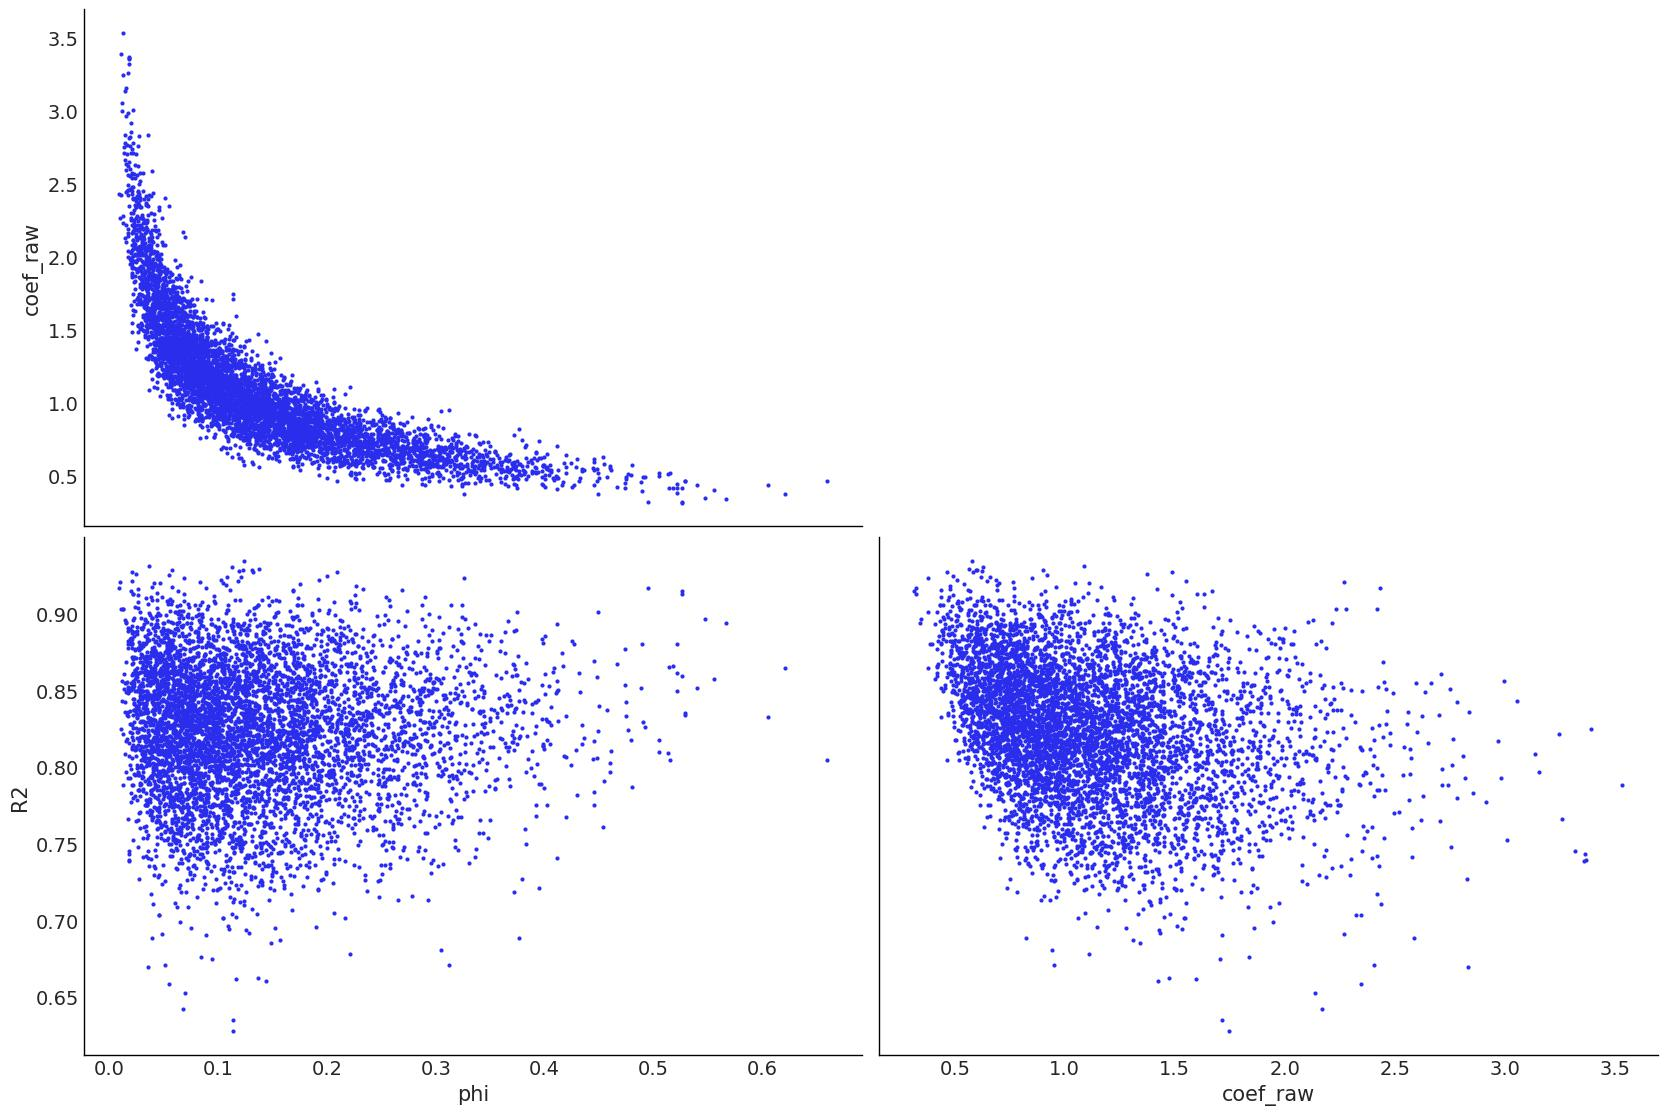

In [121]:
az.plot_pair(trace, var_names=["phi", "coef_raw", "R2"], coords=dict(variable="MedInc"));

Yet it has no divergences, the parameter landscape is very complicated.

* Larger phi discourages large coefficients.
* There is also a banana shape relationship
* Step size should be very different if you are in the center of banana or on it's boundary.
* Total sampling time on my M1 Mac book Air is almost 40 mins 🤯

### Centered R2D2M2
To my surprize, this model parametrization is 20 times faster than a non-centered variant.
Once you download the notebook, you can play around with some of the parameters below to get the idea of R2D2M2 strong or week places.
Here is the bare minimum of what you should know about the model:
* You choose R2:
    * On econometrics classes you've seen what is R2. 
    * 1 - is a perfect data fit
    * 0 - total noise and predictors are irrelevant.
    * In a Bayesian setup, you do not pick one, you pick possible ones.
    * A suggestion is to pick a $95\%$ range $(R^2_{2.5\%}, R^2_{97.5\%})$.
* You choose variable importance:
    * There usually many variables in the regression, one you might assume is more important than another.
    * $\alpha_i$ is the parameter to look into to express the knowledge.
    * $\alpha_i=1$ is total unawareness of the importance of the variable.
    * $\alpha_i<1$ tells the model you tend to think the $i$'th variable is likely to be not important.
    * $\alpha_i>1$ informs your model not to ignore the variable.
    * Extremely large or small $\alpha_i$ may cause numerical problems or divergences
        * 0.001 was too small
        * 200 was too much
        * You can explore better reasonable bounds using this notebook

In [105]:
# set irrelevant variables
U = 10
Xr = np.concatenate([X, np.random.randn(X.shape[0], U)], -1)
cols = np.concatenate([data.columns, list(map(str,range(U)))])
scaling = np.concatenate([Xscaler.scale_, np.ones(U)])
# grade the importance of variables
# 0 - least impotant, inf - most important
# 1 - "I do not know"
useful_variables_alpha = 2
wasted_variables_alpha = 0.5
alpha = np.concatenate([
    np.full(X.shape[1], useful_variables_alpha), 
    np.full(U, wasted_variables_alpha)
])
# Give me the 95% bounds of possible R2 for this linear regression
# 0 - I do not believe in this makes any sense
# 1 - I totally believe data perfectly explains the outcome 
R2 = (0.7, 0.9)

with pm.Model(coords=dict(variable=cols)) as model1:
    R2p = pm.find_constrained_prior(pm.Beta, *R2, init_guess=dict(alpha=1, beta=1))
    r2 = pm.Beta("R2", **R2p)
    tau = (r2/(1-r2)) ** .5
    phi = pm.Dirichlet("phi", alpha, dims="variable")
    beta = pm.Deterministic(
        "coef_norm", 
        pm.Normal("coef_raw", phi**.5 * tau, dims="variable") * std, 
        dims="variable"
    )
    pm.Deterministic("coef", beta/scaling, dims="variable")
    sigma = pm.HalfStudentT("sigma", 3, std)
    intercept = pm.StudentT("intercept", 3, mean, sigma=std/4)
    estimate = Xr @ beta + intercept
    nu = pm.Gamma("nu", mu=20, sigma=3)
    pm.StudentT("obs", nu, estimate, sigma=sigma, observed=target)

In [106]:
compiled_model1 = nutpie.compile_pymc_model(model1)

In [108]:
trace1 = nutpie.sample(compiled_model1)

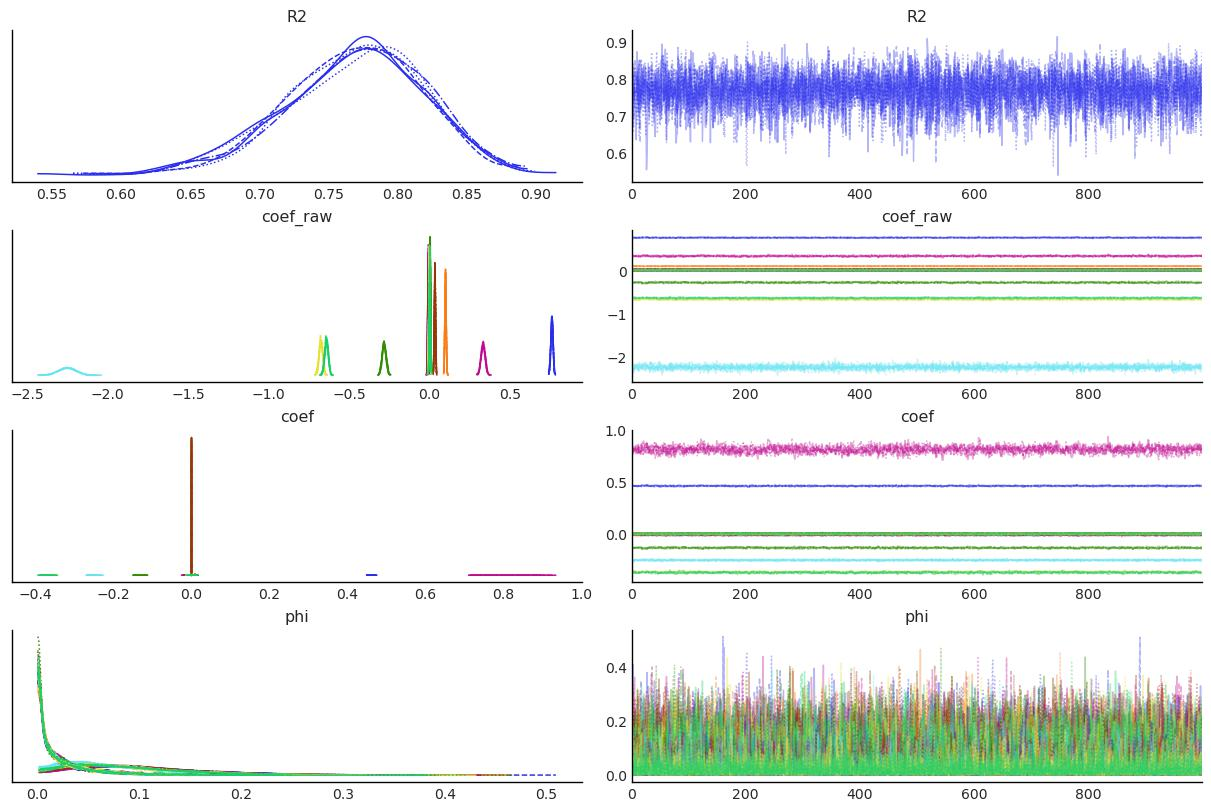

In [122]:
az.plot_trace(trace1, var_names=["R2", "coef_raw", "coef", "phi"]);
plt.tight_layout();

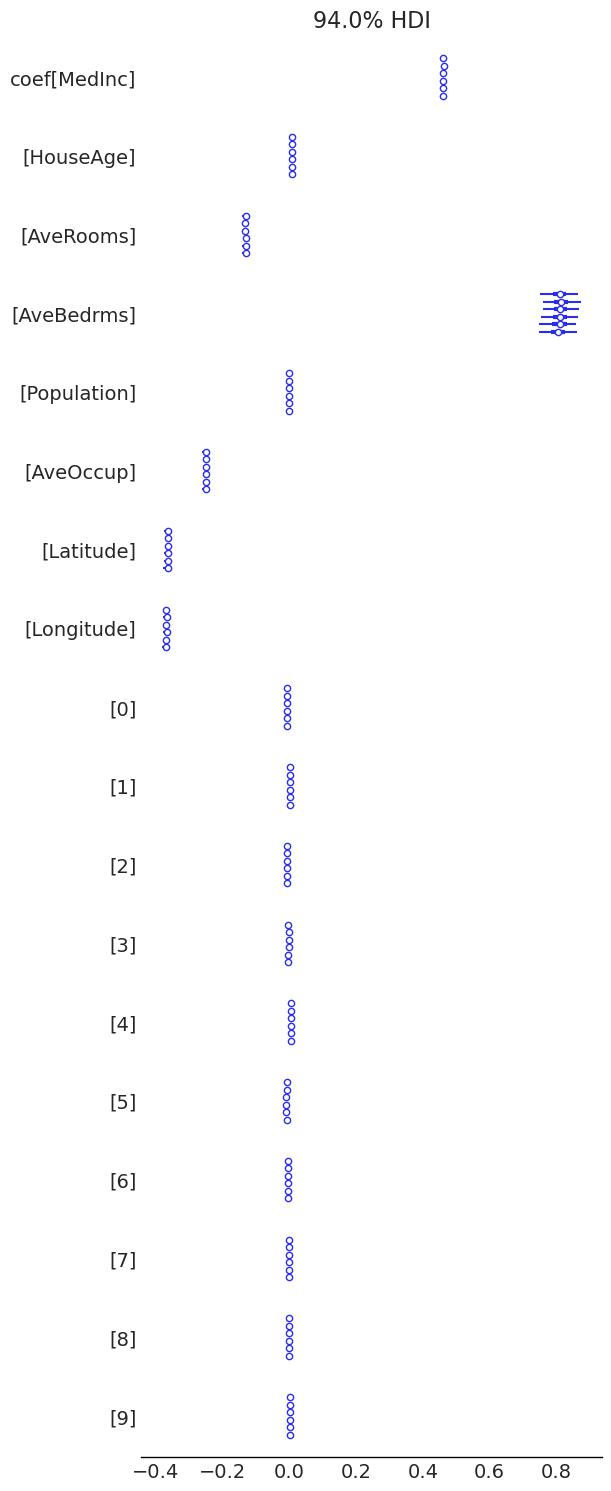

In [123]:
az.plot_forest(trace1, var_names=["coef"]);

## Prior density
Tweaking the parameters, you can see how does alpha affect the shape of the prior for the coefficients. 
The R2D2M2 prior distribution has astonishing.
I compare the tails to Cauchy, for example.

In [118]:
def prior_beta(beta, mu_r2, sigma_r2, alpha):
    a2 = (1 - mu_r2)/sigma_r2
    eta = a2 + 1/2
    nu = 3/2 - alpha
    return (
        1
        /(np.pi ** .5)
        /sp.beta(alpha, a2)
        *sp.gamma(eta)
        *sp.hyperu(eta, nu, abs(beta)) 
    )

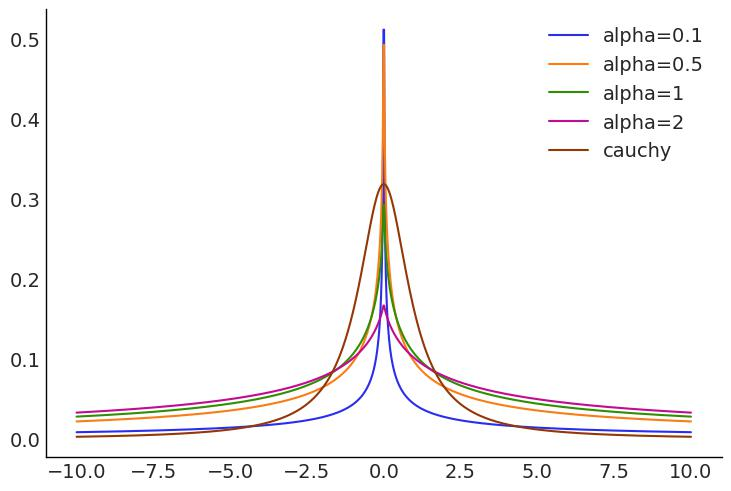

In [124]:
x = np.linspace(-10, 10, 1000)
p = prior_beta(x, 0.9, 0.4, 0.1)
plt.plot(x, p, label="alpha=0.1");
p = prior_beta(x, 0.9, 0.4, 0.5)
plt.plot(x, p, label="alpha=0.5");
p = prior_beta(x, 0.9, 0.4, 1)
plt.plot(x, p, label="alpha=1");
p = prior_beta(x, 0.9, 0.4, 2)
plt.plot(x, p, label="alpha=2");
p = st.cauchy.pdf(x, 0, 1)
plt.plot(x, p, label="cauchy");
plt.legend();